# Import libraries

In [3]:
# Importing required libraries
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score
from transformers import AutoModel, DistilBertTokenizer
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from google.colab import drive
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import numpy as np
import gdown
import torch
import os

In [4]:
# Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


# Downloading dataset

In [5]:
# Download datasets from google drive
gdown.download('https://drive.google.com/uc?id=1LvG6WhwLCmaG_5S0N0n0Z5l1Qwgo4UHj', 'train.csv', quiet=False)
gdown.download('https://drive.google.com/uc?id=1MNSnY3AboO90-o8-XtsCo7NVAaVFHx3r', 'val.csv', quiet=False)

train_df = pd.read_csv('train.csv').drop(columns=['Unnamed: 0'])
val_df = pd.read_csv('val.csv').drop(columns=['Unnamed: 0'])

Downloading...
From: https://drive.google.com/uc?id=1LvG6WhwLCmaG_5S0N0n0Z5l1Qwgo4UHj
To: /content/train.csv
100%|██████████| 18.8M/18.8M [00:00<00:00, 42.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MNSnY3AboO90-o8-XtsCo7NVAaVFHx3r
To: /content/val.csv
100%|██████████| 1.02M/1.02M [00:00<00:00, 71.6MB/s]


In [6]:
print(train_df.head(), end='\n\n')
print(train_df.info(), end='\n\n')
print(val_df.info())

                                                text  praise  amusement  \
0  Is there some scripture you could quote me? I'...       1          0   
1  Good. Now we just need people to dislike commi...       1          0   
2                          This was driving me NUTS!       0          1   
3                         Thank you for your advice!       0          0   
4  Some do. Some don't. Blanket generalizations a...       0          0   

   anger  disapproval  confusion  interest  sadness  fear  joy  love  
0      0            0          0         1        0     0    0     0  
1      0            0          0         0        0     0    0     0  
2      0            0          0         0        0     0    0     0  
3      0            0          0         0        0     0    0     1  
4      1            1          0         0        0     0    0     0  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190102 entries, 0 to 190101
Data columns (total 11 columns):
 #   Column

# Preprocess

In [8]:
# Split train and validation X, y
X_train, y_train = train_df['text'].astype(str).values, train_df.iloc[:, 1:].values
X_val, y_val = val_df['text'].astype(str).values, val_df.iloc[:, 1:].values

# Tokenizer

In [9]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

# Model

In [ ]:
def get_optimal_max_length(texts, percentile=99):
    lengths = [len(tokenizer.tokenize(t)) for t in texts]
    optimal_max_length = int(np.percentile(lengths, percentile))
    print(f"Optimal max length: {optimal_max_length}")

get_optimal_max_length(X_train)

Optimal max length: 36


In [10]:
def tokenize_text(texts, tokenizer, max_length=64):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
        return_token_type_ids=False
    )

class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

class EmotionClassifier(nn.Module):
    def __init__(self, num_labels):
        super(EmotionClassifier, self).__init__()
        self.albert = AutoModel.from_pretrained("huawei-noah/TinyBERT_General_6L_768D")
        self.dropout1 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(self.albert.config.hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(32, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.albert(input_ids=input_ids, attention_mask=attention_mask)
        x = self.dropout1(outputs.last_hidden_state[:, 0, :])
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Train

In [11]:
# Define encodings and loaders
train_encodings = tokenize_text(X_train, tokenizer)
val_encodings = tokenize_text(X_val, tokenizer)
train_dataset = EmotionDataset(train_encodings, y_train)
val_dataset = EmotionDataset(val_encodings, y_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, prefetch_factor=4, pin_memory=True,)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2, prefetch_factor=4, pin_memory=True,)

In [ ]:
# Define model and loss and optimizer
num_labels = y_train.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionClassifier(num_labels).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=2e-2)
scaler = torch.amp.GradScaler('cuda')
model_path = "/content/drive/MyDrive/nlp_model.pth"
best_acc = 0
epochs = 20

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, weights_only=False))

In [16]:
train_losses, train_accuracies = [], []

def calculate_accuracy(preds, labels):
    preds = (torch.sigmoid(preds) > 0.5).cpu().numpy()
    labels = labels.cpu().numpy()
    return accuracy_score(labels, preds)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, model_path):
    global best_acc
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total_samples = 0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in progress_bar:
            inputs, labels = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                outputs = model(**inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
            correct += calculate_accuracy(outputs, labels) * labels.size(0)
            total_samples += labels.size(0)
            progress_bar.set_postfix(loss=loss.item(), acc=correct / total_samples)
        avg_train_loss = total_loss / len(train_loader)
        avg_train_accuracy = correct / total_samples
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}")
        model.eval()
        total_loss, correct, total_samples = 0, 0, 0
        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f"Validating {epoch+1}/{epochs}")
            for batch in progress_bar:
                inputs, labels = batch
                inputs = {key: val.to(device) for key, val in inputs.items()}
                labels = labels.to(device)
                with torch.amp.autocast('cuda'):
                    outputs = model(**inputs)
                    loss = criterion(outputs, labels)
                total_loss += loss.item()
                correct += calculate_accuracy(outputs, labels) * labels.size(0)
                total_samples += labels.size(0)
                progress_bar.set_postfix(loss=loss.item(), acc=correct / total_samples)
        avg_val_loss = total_loss / len(val_loader)
        avg_val_accuracy = correct / total_samples
        print(f"Epoch {epoch+1}/{epochs}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}")
        if avg_val_accuracy > best_acc:
            best_acc= avg_val_accuracy
            torch.save(model.state_dict(), model_path)
            print("Best model saved.")

train_model(model, train_loader, val_loader, criterion, optimizer, 10, model_path)

Epoch 1/10: 100%|██████████| 2971/2971 [04:58<00:00,  9.94it/s, acc=0.233, loss=0.226]


Epoch 1/10, Train Loss: 0.2792, Train Acc: 0.2329


Validating 1/10: 100%|██████████| 166/166 [00:04<00:00, 33.41it/s, acc=0.266, loss=0.203]


Epoch 1/10, Val Loss: 0.2457, Val Acc: 0.2662
Best model saved.


Epoch 2/10: 100%|██████████| 2971/2971 [04:58<00:00,  9.96it/s, acc=0.269, loss=0.275]


Epoch 2/10, Train Loss: 0.2612, Train Acc: 0.2695


Validating 2/10: 100%|██████████| 166/166 [00:05<00:00, 33.17it/s, acc=0.269, loss=0.178]


Epoch 2/10, Val Loss: 0.2437, Val Acc: 0.2685
Best model saved.


Epoch 3/10: 100%|██████████| 2971/2971 [04:56<00:00, 10.02it/s, acc=0.296, loss=0.256]


Epoch 3/10, Train Loss: 0.2514, Train Acc: 0.2965


Validating 3/10: 100%|██████████| 166/166 [00:04<00:00, 33.29it/s, acc=0.305, loss=0.179]


Epoch 3/10, Val Loss: 0.2442, Val Acc: 0.3050
Best model saved.


Epoch 4/10: 100%|██████████| 2971/2971 [04:56<00:00, 10.01it/s, acc=0.315, loss=0.194]


Epoch 4/10, Train Loss: 0.2447, Train Acc: 0.3151


Validating 4/10: 100%|██████████| 166/166 [00:05<00:00, 32.21it/s, acc=0.314, loss=0.237]


Epoch 4/10, Val Loss: 0.2473, Val Acc: 0.3140
Best model saved.


Epoch 5/10: 100%|██████████| 2971/2971 [04:59<00:00,  9.93it/s, acc=0.329, loss=0.258]


Epoch 5/10, Train Loss: 0.2389, Train Acc: 0.3295


Validating 5/10: 100%|██████████| 166/166 [00:05<00:00, 32.18it/s, acc=0.292, loss=0.231]


Epoch 5/10, Val Loss: 0.2496, Val Acc: 0.2917


Epoch 6/10: 100%|██████████| 2971/2971 [04:57<00:00,  9.98it/s, acc=0.342, loss=0.231]


Epoch 6/10, Train Loss: 0.2342, Train Acc: 0.3422


Validating 6/10: 100%|██████████| 166/166 [00:04<00:00, 34.07it/s, acc=0.31, loss=0.236]


Epoch 6/10, Val Loss: 0.2534, Val Acc: 0.3096


Epoch 7/10: 100%|██████████| 2971/2971 [04:56<00:00, 10.01it/s, acc=0.352, loss=0.232]


Epoch 7/10, Train Loss: 0.2296, Train Acc: 0.3523


Validating 7/10: 100%|██████████| 166/166 [00:04<00:00, 34.92it/s, acc=0.299, loss=0.241]


Epoch 7/10, Val Loss: 0.2535, Val Acc: 0.2990


Epoch 8/10: 100%|██████████| 2971/2971 [04:56<00:00, 10.03it/s, acc=0.359, loss=0.254]


Epoch 8/10, Train Loss: 0.2259, Train Acc: 0.3593


Validating 8/10: 100%|██████████| 166/166 [00:04<00:00, 34.83it/s, acc=0.307, loss=0.312]


Epoch 8/10, Val Loss: 0.2606, Val Acc: 0.3074


Epoch 9/10: 100%|██████████| 2971/2971 [04:57<00:00,  9.99it/s, acc=0.366, loss=0.238]


Epoch 9/10, Train Loss: 0.2224, Train Acc: 0.3663


Validating 9/10: 100%|██████████| 166/166 [00:04<00:00, 34.71it/s, acc=0.325, loss=0.264]


Epoch 9/10, Val Loss: 0.2658, Val Acc: 0.3247
Best model saved.


Epoch 10/10: 100%|██████████| 2971/2971 [05:02<00:00,  9.81it/s, acc=0.373, loss=0.227]


Epoch 10/10, Train Loss: 0.2192, Train Acc: 0.3725


Validating 10/10: 100%|██████████| 166/166 [00:05<00:00, 30.96it/s, acc=0.331, loss=0.251]


Epoch 10/10, Val Loss: 0.2754, Val Acc: 0.3307
Best model saved.


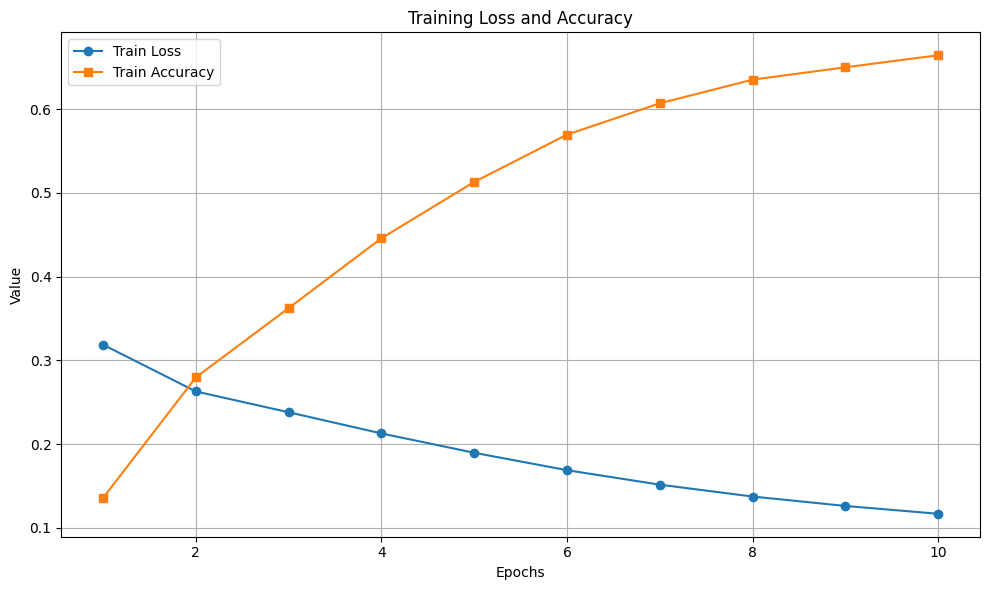

In [ ]:
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', linestyle='-', marker='o')
plt.plot(epochs, train_accuracies, label='Train Accuracy', linestyle='-', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation

In [17]:
# Download final test dataset
gdown.download('https://drive.google.com/uc?id=1J5Mss5mgSqMmniSmV0V3LUOzlovoevg7', 'test.csv', quiet=False)
test_df = pd.read_csv('test.csv').drop(columns=['index'])
X_test, y_test = test_df['text'].astype(str).values, test_df.iloc[:, 1:].values
test_encodings = tokenize_text(X_test, tokenizer)
test_dataset = EmotionDataset(test_encodings, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Downloading...
From: https://drive.google.com/uc?id=1J5Mss5mgSqMmniSmV0V3LUOzlovoevg7
To: /content/test.csv
100%|██████████| 98.6k/98.6k [00:00<00:00, 52.7MB/s]


In [18]:
def evaluate_model(model, test_loader, label_names, test_texts, true_labels, test=True):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = labels.to(device)
            outputs = model(**inputs)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds) > 0.5  # Convert probabilities to binary predictions
    all_labels = np.vstack(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="micro")
    recall = recall_score(all_labels, all_preds, average="micro")
    f1_micro = f1_score(all_labels, all_preds, average="micro")
    f1_macro = f1_score(all_labels, all_preds, average="macro")
    f1_weighted = f1_score(all_labels, all_preds, average="weighted")
    jaccard = jaccard_score(all_labels, all_preds, average="samples")

    print("\n\nOverall Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Micro: {f1_micro:.4f}")
    print(f"F1 Macro: {f1_macro:.4f}")
    print(f"F1 Weighted: {f1_weighted:.4f}")
    print(f"Jaccard Score: {jaccard:.4f}")
    print("\nClass-wise Metrics:")
    class_f1_macro = f1_score(all_labels, all_preds, average="macro")
    class_f1_weighted = f1_score(all_labels, all_preds, average="weighted")
    class_precision = precision_score(all_labels, all_preds, average=None)
    class_recall = recall_score(all_labels, all_preds, average=None)

    for i, label in enumerate(label_names):
        print(f"{label}: Precision:{class_precision[i]:.4f}, Recall: {class_recall[i]:.4f}, F1 Macro: {class_f1_macro:.4f}, F1 Weighted: {class_f1_weighted:.4f}")
    print()

    for i in (range(10) if test else range(len(test_texts))):
        predicted_labels = [label_names[j] for j in range(len(label_names)) if all_preds[i][j]]
        true_labels_list = [label_names[j] for j in range(len(label_names)) if true_labels[i][j]]
        print(f"Text: {test_texts[i]}\nPredicted Emotions: {predicted_labels}\nTrue Emotions: {true_labels_list}\n")

def evaluate_by_emotion_count(model, test_loader, label_names, test_texts, true_labels):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = labels.to(device)
            outputs = model(**inputs)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds) > 0.5  # Convert probabilities to binary predictions
    all_labels = np.vstack(all_labels)

    sentence_emotion_counts = np.sum(all_labels, axis=1)

    for count in [1, 2, 3]:                 # Evaluating sentences with 1, 2, and 3 emotions:
        indices = np.where(sentence_emotion_counts == count)[0]

        subset_preds = all_preds[indices]
        subset_labels = all_labels[indices]
        subset_true_labels = true_labels[indices]  # Get the true labels for the subset

        accuracy = accuracy_score(subset_labels, subset_preds)
        precision = precision_score(subset_labels, subset_preds, average="micro")
        recall = recall_score(subset_labels, subset_preds, average="micro")
        f1_micro = f1_score(subset_labels, subset_preds, average="micro")
        f1_macro = f1_score(subset_labels, subset_preds, average="macro")
        f1_weighted = f1_score(subset_labels, subset_preds, average="weighted")
        jaccard = jaccard_score(subset_labels, subset_preds, average="samples")

        print(f"\nSentences with {count} emotions:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Micro: {f1_micro:.4f}")
        print(f"F1 Macro: {f1_macro:.4f}")
        print(f"F1 Weighted: {f1_weighted:.4f}")
        print(f"Jaccard Score: {jaccard:.4f}")
        print("\nSample Predictions:")

        for idx, i in enumerate(indices[:5]):  # Use idx for safe indexing in subset_preds
            if idx >= len(subset_preds):       # Ensure we don't go out of bounds
                print(f"Skipping index {i} as it exceeds subset_preds length.")
                continue
            predicted_labels = [
                label_names[j] for j in range(min(len(label_names), subset_preds.shape[1])) if subset_preds[idx][j]
            ]
            true_emotions = [
                label_names[j] for j in range(len(label_names)) if subset_true_labels[idx][j]
            ]
            print(f"Text: {test_texts[i]}")
            print(f"Predicted Emotions: {predicted_labels}")
            print(f"True Emotions: {true_emotions}\n")

In [19]:
label_names = train_df.columns[1:].tolist()
print('Validation Overall Evaluation:\n')
evaluate_model(model, val_loader, label_names, X_val, y_val)
print('Validation Per Class Evaluation:\n')
evaluate_by_emotion_count(model, val_loader, label_names, X_val, y_val)

Validation Overall Evaluation:



Evaluating: 100%|██████████| 166/166 [00:15<00:00, 10.51it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




Overall Metrics:
Accuracy: 0.3311
Precision: 0.5803
Recall: 0.3618
F1 Micro: 0.4457
F1 Macro: 0.3903
F1 Weighted: 0.4287
Jaccard Score: 0.3635

Class-wise Metrics:
praise: Precision:0.5695, Recall: 0.3981, F1 Macro: 0.3903, F1 Weighted: 0.4287
amusement: Precision:0.6069, Recall: 0.2889, F1 Macro: 0.3903, F1 Weighted: 0.4287
anger: Precision:0.5443, Recall: 0.2069, F1 Macro: 0.3903, F1 Weighted: 0.4287
disapproval: Precision:0.4402, Recall: 0.1336, F1 Macro: 0.3903, F1 Weighted: 0.4287
confusion: Precision:0.5948, Recall: 0.4559, F1 Macro: 0.3903, F1 Weighted: 0.4287
interest: Precision:0.4151, Recall: 0.2082, F1 Macro: 0.3903, F1 Weighted: 0.4287
sadness: Precision:0.4992, Recall: 0.3839, F1 Macro: 0.3903, F1 Weighted: 0.4287
fear: Precision:0.6832, Recall: 0.2782, F1 Macro: 0.3903, F1 Weighted: 0.4287
joy: Precision:0.5439, Recall: 0.1603, F1 Macro: 0.3903, F1 Weighted: 0.4287
love: Precision:0.6814, Recall: 0.6536, F1 Macro: 0.3903, F1 Weighted: 0.4287

Text: This is the same fede

Evaluating: 100%|██████████| 166/166 [00:15<00:00, 10.41it/s]



Sentences with 1 emotions:
Accuracy: 0.3790
Precision: 0.5600
Recall: 0.3941
F1 Micro: 0.4626
F1 Macro: 0.4061
F1 Weighted: 0.4513
Jaccard Score: 0.3865

Sample Predictions:
Text: This is the same federal government that's been shut down for the last month?
Predicted Emotions: ['interest']
True Emotions: ['confusion']

Text: But in an even lower res
Predicted Emotions: ['confusion']
True Emotions: ['confusion']

Text: Don't be so hard on yourself. Often, things need time. Don't beat yourself up over it. 
Predicted Emotions: []
True Emotions: ['love']

Text: Don't worry. You'll grow out of Pearl Jam.
Predicted Emotions: ['love']
True Emotions: ['love']

Text: That guy at the start with the hat reminds me of [NAME]
Predicted Emotions: ['confusion']
True Emotions: ['love']


Sentences with 2 emotions:
Accuracy: 0.0574
Precision: 0.7302
Recall: 0.2877
F1 Micro: 0.4128
F1 Macro: 0.3544
F1 Weighted: 0.3868
Jaccard Score: 0.2833

Sample Predictions:
Text: The Sunshine Skyway Bridge? I'm near

In [20]:
print('Test Overall Evaluation:\n')
evaluate_model(model, test_loader, label_names, X_test, y_test, False)
print('Test Per Class Evaluation:\n')
evaluate_by_emotion_count(model, test_loader, label_names, X_test, y_test)

Test Overall Evaluation:



Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.29it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




Overall Metrics:
Accuracy: 0.3530
Precision: 0.6028
Recall: 0.3751
F1 Micro: 0.4625
F1 Macro: 0.3991
F1 Weighted: 0.4449
Jaccard Score: 0.3823

Class-wise Metrics:
praise: Precision:0.5833, Recall: 0.4192, F1 Macro: 0.3991, F1 Weighted: 0.4449
amusement: Precision:0.6857, Recall: 0.3529, F1 Macro: 0.3991, F1 Weighted: 0.4449
anger: Precision:0.7241, Recall: 0.2100, F1 Macro: 0.3991, F1 Weighted: 0.4449
disapproval: Precision:0.4737, Recall: 0.1200, F1 Macro: 0.3991, F1 Weighted: 0.4449
confusion: Precision:0.5904, Recall: 0.4742, F1 Macro: 0.3991, F1 Weighted: 0.4449
interest: Precision:0.5312, Recall: 0.2464, F1 Macro: 0.3991, F1 Weighted: 0.4449
sadness: Precision:0.4688, Recall: 0.3529, F1 Macro: 0.3991, F1 Weighted: 0.4449
fear: Precision:0.7500, Recall: 0.1714, F1 Macro: 0.3991, F1 Weighted: 0.4449
joy: Precision:0.5833, Recall: 0.2000, F1 Macro: 0.3991, F1 Weighted: 0.4449
love: Precision:0.7034, Recall: 0.6535, F1 Macro: 0.3991, F1 Weighted: 0.4449

Text: Yeah that's about wha

Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.46it/s]


Sentences with 1 emotions:
Accuracy: 0.4064
Precision: 0.5980
Recall: 0.4255
F1 Micro: 0.4972
F1 Macro: 0.4295
F1 Weighted: 0.4854
Jaccard Score: 0.4160

Sample Predictions:
Text: Yeah that's about what I found. Not that specific page but I got into "My Profile" 
Predicted Emotions: []
True Emotions: ['amusement']

Text: First bad melee, then off the sticks.. what next?
Predicted Emotions: ['interest']
True Emotions: ['confusion']

Text: Tough deal haha. The recall just happened though so you may still have time.
Predicted Emotions: ['joy']
True Emotions: ['confusion']

Text: [NAME], [NAME], [NAME], hey [NAME]. [NAME]! I’m a prostitute robot from the future.
Predicted Emotions: ['confusion']
True Emotions: ['praise']

Text: Nah when Telus does it so will Koodo since fido did
Predicted Emotions: ['confusion']
True Emotions: ['confusion']


Sentences with 2 emotions:
Accuracy: 0.0385
Precision: 0.6889
Recall: 0.2385
F1 Micro: 0.3543
F1 Macro: 0.3116
F1 Weighted: 0.3268
Jaccard Score: 0.